In [1]:
import sys, os
import numpy as np
import time, h5py
codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import default_paths, coco_utils, nsd_utils
from utils import segmentation_utils, prf_utils, texture_utils
from model_fitting import initialize_fitting 
import pandas as pd
from skimage import io
import copy
from matplotlib import pyplot as plt
import PIL

Initializing coco api...
loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
loading annotations into memory...
Done (t=18.87s)
creating index...
index created!
Initializing coco api...
loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
loading annotations into memory...
Done (t=21.87s)
creating index...
index created!


In [2]:
# Get ready for some tests - load basic things for a subject
subject = 8
ims = nsd_utils.get_image_data(subject)
subject_df = nsd_utils.get_subj_df(subject);
all_coco_ids = np.array(subject_df['cocoId'])


Loading images for subject 8

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255


things labels:
['accessory', 'food', 'person']
['person.1', 'handbag', 'banana', 'orange']
stuff labels:
['floor', 'food-stuff', 'furniture-stuff', 'ground', 'other', 'plant', 'raw-material', 'solid', 'textile', 'wall']
['cardboard', 'cloth', 'clothes', 'floor-tile', 'fruit', 'paper', 'pavement', 'plant-other', 'plastic', 'table', 'vegetable', 'wall-wood', 'wood', 'other.1']


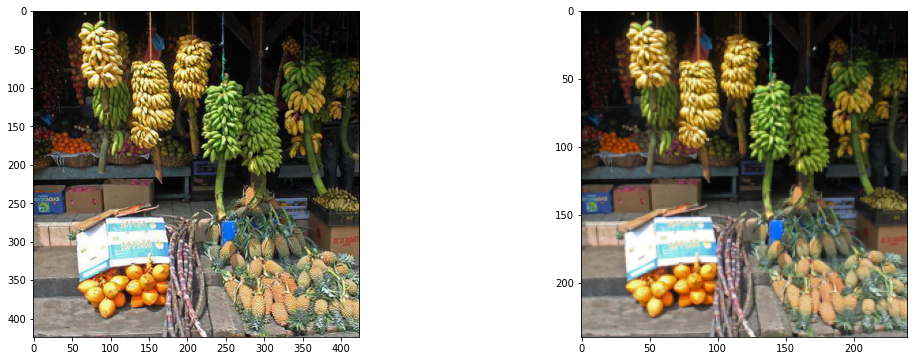

In [16]:
# Check the coco labels for example image

image_ind = np.random.choice(np.arange(0,10000), 1)[0]
# image_ind = 1
nsd_image = np.moveaxis(ims[image_ind,:,:,:],[0,1,2],[2,0,1])

# Print things labels for the whole image
df = pd.read_csv(os.path.join(default_paths.stim_labels_root, \
                             'S%d_cocolabs_binary.csv'%subject), index_col=0)
supcat_names = list(df.keys())[0:12]
cat_names = list(df.keys()[12:92])

print('things labels:')
print([sname for sname in supcat_names if df[sname][image_ind]==1 ])
print([cname for cname in cat_names if df[cname][image_ind]==1 ])
 
# Print stuff labels for the whole image
df = pd.read_csv(os.path.join(default_paths.stim_labels_root, \
                             'S%d_cocolabs_stuff_binary.csv'%subject), index_col=0)
supcat_names = list(df.keys())[0:16]
cat_names = list(df.keys()[16:108])

print('stuff labels:')
print([sname for sname in supcat_names if df[sname][image_ind]==1 ])
print([cname for cname in cat_names if df[cname][image_ind]==1 ])
 
# loading the image from two different places to make sure it is the same one   
cocoid = np.array(subject_df['cocoId'])[image_ind]
cocoim = '/lab_data/tarrlab/common/datasets/NSD_images/images/%d.jpg'%cocoid
coco_image = PIL.Image.open(cocoim)

plt.figure(figsize=(18,6));
plt.subplot(1,2,1)
plt.imshow(coco_image)

plt.subplot(1,2,2)
plt.imshow(nsd_image)

In [24]:
# Params for the spatial aspect of the model (possible pRFs)
which_prf_grid=5
models = initialize_fitting.get_prf_models(which_grid=which_prf_grid)    

# prf_ind = 1
# prf_ind = 822
# prf_ind = 1455
# prf_ind = 697
prf_ind = 215
# prf_ind = 831
# prf_ind = 512


prf_params = models[prf_ind,:]    
x,y,sigma = prf_params
# n_pix = 240
n_pix = nsd_image.shape[0]
aperture=1.0
prf = prf_utils.gauss_2d(center=[x, y], sd=sigma, patch_size=n_pix, aperture=1.0, \
                                      dtype=np.float32)
prf_mask = prf_utils.get_prf_mask(center=[x, y], sd=sigma, patch_size=n_pix)
mask_sum = np.sum(prf_mask)
min_pix_req = np.ceil(mask_sum*0.10)

n_prf_sd_out = 2
prf_bbox = texture_utils.get_bbox_from_prf(prf_params, (n_pix, n_pix), n_prf_sd_out, \
                                                   min_pix=None, verbose=False, force_square=False)

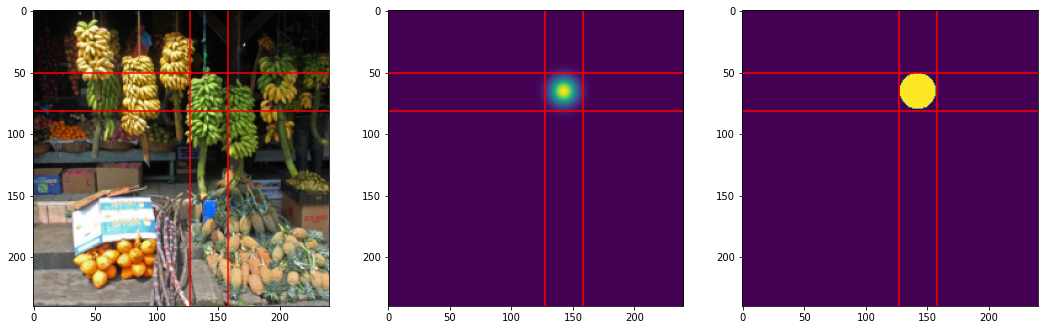

In [25]:
# Check pRF bounding boxes

plt.figure(figsize=(18,6));
plt.subplot(1,3,1)
plt.imshow(nsd_image)
# show the prf on top to make sure it is where it should be
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(1,3,2)
plt.imshow(prf)
# plt.colorbar()
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(1,3,3)
plt.imshow(prf_mask)
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')


In [26]:
# Now checking the annotation labels within pRFs separately 

# Get things annotations for this image
cocoid = np.array(subject_df['cocoId'])[image_ind]
# figure out if it's training or val set and create the right coco api dataset
if np.array(subject_df['cocoSplit'])[image_ind]=='val2017':
    coco = coco_utils.coco_val 
    coco_image_dir = '/lab_data/tarrlab/common/datasets/COCO/val2017'
else:
    coco = coco_utils.coco_trn
    coco_image_dir = '/lab_data/tarrlab/common/datasets/COCO/train2017'
      
cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = coco_utils.get_coco_cat_info(coco_utils.coco_val)

annotations = coco.loadAnns(coco.getAnnIds(imgIds=[cocoid]))
masks = np.array([coco.annToMask(annotations[aa]) for aa in range(len(annotations))])

# Print all the categories that are annotated anywhere in the image
print('in whole image:')
ann_cats = [annotations[aa]['category_id'] for aa in range(len(annotations))]
print(ann_cats)
ann_cat_names = [cat_names[cc] for cc in range(len(cat_names)) \
                if cat_ids[cc] in ann_cats]
print(ann_cat_names)

# How was the image cropped to get from coco original to NSD?
# Need this to know how to adjust object segmentations
img_info = coco.loadImgs(ids=[cocoid])[0]
crop_box_pixels = segmentation_utils.get_crop_box_pixels(np.array(subject_df['cropBox'])[image_ind], \
                                                         [img_info['height'], img_info['width']])

# Figure out which annotations overlap with my pRF of interest (defined above)
masks_final = np.zeros((masks.shape[0], n_pix, n_pix))
for aa in range(len(annotations)):
    
    mask = masks[aa,:,:]
    mask_cropped = mask[crop_box_pixels[0]:crop_box_pixels[1], crop_box_pixels[2]:crop_box_pixels[3]]
    newsize=[n_pix, n_pix]
    mask_cropped_resized = np.asarray(PIL.Image.fromarray(mask_cropped).resize(newsize, resample=PIL.Image.BILINEAR))

    masks_final[aa,:,:] = mask_cropped_resized

has_overlap = np.tensordot(masks_final, prf_mask, [[1,2], [0,1]])>min_pix_req

print('\nin pRF:')
print(has_overlap)

print(np.array(ann_cats)[has_overlap])
print([cat_names[cc] for cc in range(len(cat_names)) \
                if cat_ids[cc] in np.array(ann_cats)[has_overlap]])
print([supcat_names[sc] for sc in range(len(supcat_names)) \
    if np.any(np.isin(np.array(ann_cats)[has_overlap] , ids_each_supcat[sc]))])

in whole image:
[52, 52, 52, 52, 52, 52, 52, 55, 1, 31, 52, 52, 52, 52, 1, 55]
['person', 'handbag', 'banana', 'orange']

in pRF:
[False False False False  True False False False False False False False
 False False False False]
[52]
['banana']
['food']


In [27]:
# Make sure my saved labels match this same thing

df = pd.read_csv(os.path.join(default_paths.stim_labels_root, 'S%d_within_prf_grid%d'%(subject, which_prf_grid), \
                             'S%d_cocolabs_binary_prf%d.csv'%(subject, prf_ind)), index_col=0)
print([kk for kk in df.keys() if df[kk].loc[image_ind]==1])


['food', 'banana']


52
['banana']


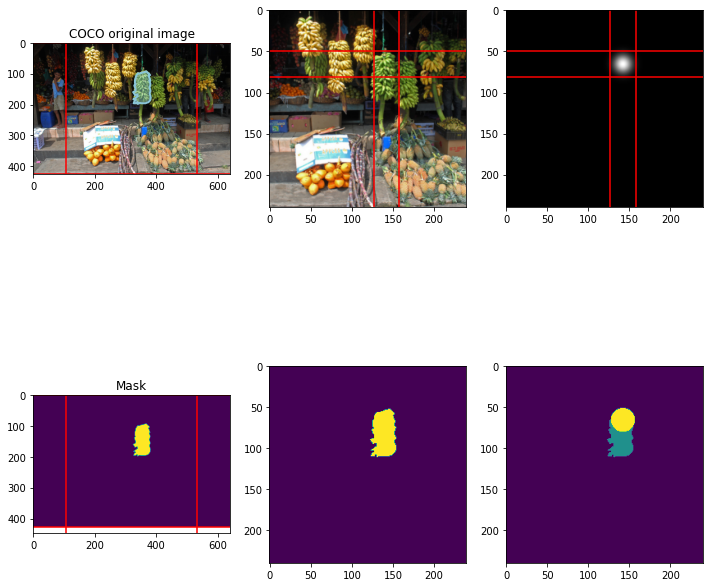

In [28]:
# Now visualizing the actual masks
if np.any(has_overlap==1):
    annot2plot = np.where(has_overlap==1)[0][0]
#     annot2plot = 2
else:
    annot2plot = 0
    
plt.figure(figsize=(12,12));

plt.subplot(2,3,1)
imfn = os.path.join(coco_image_dir, img_info['file_name'])
coco_im = io.imread(imfn)
plt.imshow(coco_im); plt.title('COCO original image')
# coco.showAnns(annotations)
coco.showAnns([annotations[annot2plot]])
plt.axhline([crop_box_pixels[0]],color='r')
plt.axhline([crop_box_pixels[1]],color='r')
plt.axvline([crop_box_pixels[2]],color='r')
plt.axvline([crop_box_pixels[3]],color='r')

plt.subplot(2,3,2)
plt.imshow(nsd_image)
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(2,3,3)
plt.imshow(prf,cmap='gray')
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(2,3,4)

mask = masks[annot2plot,:,:]

plt.imshow(mask); plt.title('Mask')
plt.axhline([crop_box_pixels[0]],color='r')
plt.axhline([crop_box_pixels[1]],color='r')
plt.axvline([crop_box_pixels[2]],color='r')
plt.axvline([crop_box_pixels[3]],color='r')

plt.subplot(2,3,5)
mask_cropped_resized = masks_final[annot2plot,:,:]
plt.imshow(mask_cropped_resized)

plt.subplot(2,3,6)
mask_plus_prf = copy.deepcopy(mask_cropped_resized)
mask_plus_prf[prf_mask==1] = 2
plt.imshow(mask_plus_prf)

print(ann_cats[annot2plot])

print([cat_names[cc] for cc in range(len(cat_names)) \
                if cat_ids[cc] in [np.array(ann_cats)[annot2plot]]])


In [29]:
# Now same thing but with the STUFF labels

# Get things annotations for this image
cocoid = np.array(subject_df['cocoId'])[image_ind]
# figure out if it's training or val set and create the right coco api dataset
if np.array(subject_df['cocoSplit'])[image_ind]=='val2017':
    coco = coco_utils.coco_stuff_val 
    coco_image_dir = '/lab_data/tarrlab/common/datasets/COCO/val2017'
else:
    coco = coco_utils.coco_stuff_trn
    coco_image_dir = '/lab_data/tarrlab/common/datasets/COCO/train2017'
      
cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = \
            coco_utils.get_coco_cat_info(coco_utils.coco_stuff_val)

        
annotations = coco.loadAnns(coco.getAnnIds(imgIds=[cocoid]))
masks = np.array([coco.annToMask(annotations[aa]) for aa in range(len(annotations))])

# Print all the categories that are annotated anywhere in the image
print('in whole image:')
ann_cats = [annotations[aa]['category_id'] for aa in range(len(annotations))]
print(ann_cats)
ann_cat_names = [cat_names[cc] for cc in range(len(cat_names)) \
                if cat_ids[cc] in ann_cats]
print(ann_cat_names)

# How was the image cropped to get from coco original to NSD?
# Need this to know how to adjust object segmentations
img_info = coco.loadImgs(ids=[cocoid])[0]
crop_box_pixels = segmentation_utils.get_crop_box_pixels(np.array(subject_df['cropBox'])[image_ind], \
                                                         [img_info['height'], img_info['width']])

# Figure out which annotations overlap with my pRF of interest (defined above)
masks_final = np.zeros((masks.shape[0], n_pix, n_pix))
for aa in range(len(annotations)):
    
    mask = masks[aa,:,:]
    mask_cropped = mask[crop_box_pixels[0]:crop_box_pixels[1], crop_box_pixels[2]:crop_box_pixels[3]]
    newsize=[n_pix, n_pix]
    mask_cropped_resized = np.asarray(PIL.Image.fromarray(mask_cropped).resize(newsize, resample=PIL.Image.BILINEAR))

    masks_final[aa,:,:] = mask_cropped_resized

has_overlap = np.tensordot(masks_final, prf_mask, [[1,2], [0,1]])>min_pix_req

print('\nin pRF:')
print(has_overlap)

print(np.array(ann_cats)[has_overlap])
print([cat_names[cc] for cc in range(len(cat_names)) \
                if cat_ids[cc] in np.array(ann_cats)[has_overlap]])
print([supcat_names[sc] for sc in range(len(supcat_names)) \
    if np.any(np.isin(np.array(ann_cats)[has_overlap] , ids_each_supcat[sc]))])

in whole image:
[100, 104, 105, 117, 122, 139, 140, 142, 143, 165, 170, 177, 182, 183]
['cardboard', 'cloth', 'clothes', 'floor-tile', 'fruit', 'paper', 'pavement', 'plant-other', 'plastic', 'table', 'vegetable', 'wall-wood', 'wood', 'other']

in pRF:
[False False False False False False False False False False False False
 False  True]
[183]
['other']
['other']


In [30]:
# Make sure my saved labels match this same thing

df = pd.read_csv(os.path.join(default_paths.stim_labels_root, 'S%d_within_prf_grid%d'%(subject, which_prf_grid), \
                             'S%d_cocolabs_stuff_binary_prf%d.csv'%(subject, prf_ind)), index_col=0)
print([kk for kk in df.keys() if df[kk].loc[image_ind]==1])


['other', 'other.1']


183
['other']


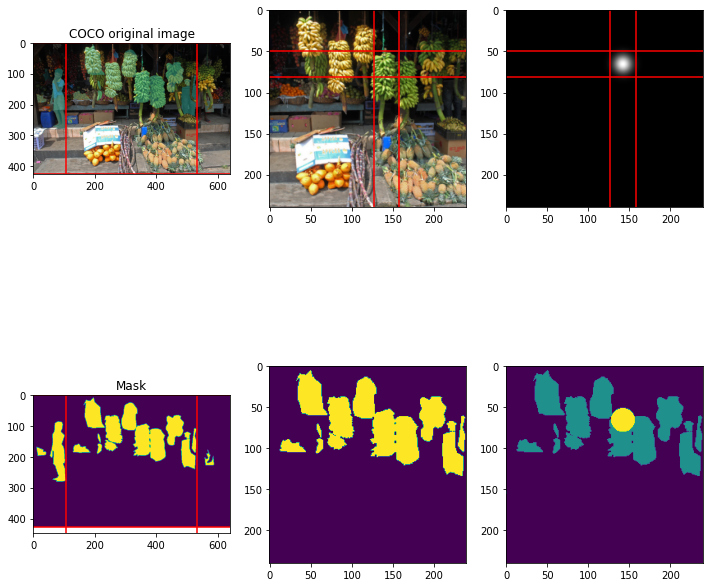

In [31]:
# Now visualizing the actual masks
if np.any(has_overlap==1):
    annot2plot = np.where(has_overlap==1)[0][0]
#     annot2plot = 2
else:
    annot2plot = 0
    
plt.figure(figsize=(12,12));

plt.subplot(2,3,1)
imfn = os.path.join(coco_image_dir, img_info['file_name'])
coco_im = io.imread(imfn)
plt.imshow(coco_im); plt.title('COCO original image')
# coco.showAnns(annotations)
coco.showAnns([annotations[annot2plot]])
plt.axhline([crop_box_pixels[0]],color='r')
plt.axhline([crop_box_pixels[1]],color='r')
plt.axvline([crop_box_pixels[2]],color='r')
plt.axvline([crop_box_pixels[3]],color='r')

plt.subplot(2,3,2)
plt.imshow(nsd_image)
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(2,3,3)
plt.imshow(prf,cmap='gray')
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(2,3,4)

mask = masks[annot2plot,:,:]

plt.imshow(mask); plt.title('Mask')
plt.axhline([crop_box_pixels[0]],color='r')
plt.axhline([crop_box_pixels[1]],color='r')
plt.axvline([crop_box_pixels[2]],color='r')
plt.axvline([crop_box_pixels[3]],color='r')

plt.subplot(2,3,5)
mask_cropped_resized = masks_final[annot2plot,:,:]
plt.imshow(mask_cropped_resized)

plt.subplot(2,3,6)
mask_plus_prf = copy.deepcopy(mask_cropped_resized)
mask_plus_prf[prf_mask==1] = 2
plt.imshow(mask_plus_prf)

print(ann_cats[annot2plot])

print([cat_names[cc] for cc in range(len(cat_names)) \
                if cat_ids[cc] in [np.array(ann_cats)[annot2plot]]])


In [32]:
min_pix_req

68.0